In [3]:
import os
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn import tree
import numpy as np
import pandas as pd
import pickle
from random import sample 

# Read Dataset

In [4]:
path = "../predict-responsibly/data/"
dataset = "adult"
protected_feature = "sex"
K = 1
db = np.load(os.path.join(path,dataset,"{}{}_{}.npz".format(dataset,K,protected_feature)))

## partition X according to f0

In [23]:
x_train = db["x_train"]
X_0 = x_train[(db["ydm_train"]<=0.5).reshape(-1),:]
X_1 = x_train[(db["ydm_train"]>0.5).reshape(-1),:]
S = np.concatenate((x_train,X_0,X_1),axis=0)

In [33]:
y_val = db["y_train"]

没有看到partion的意义

Text(0, 0.5, 'Residual')

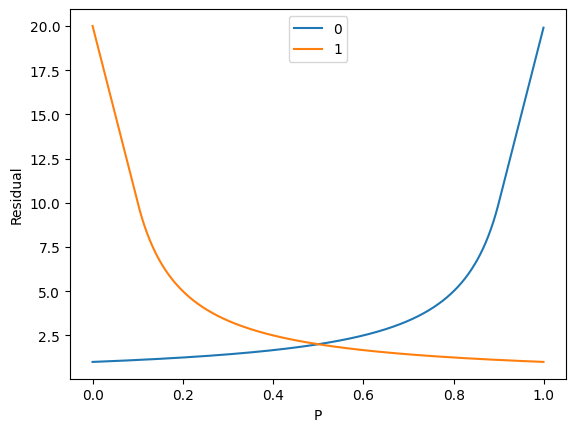

In [32]:
import matplotlib.pyplot as plt
def res(p, y):
    return y * ((p>=0.1)/(p + 1e-20) + (p<0.1) * (20 - 100  * p)) +\
(1-y) * ((p < 0.9)/(1 - p + 1e-20) + (p>=0.9) * (100 * p - 80))
plt.plot(np.arange(0, 1.0, 0.001), res(np.arange(0., 1, 0.001), 0))
plt.plot(np.arange(0, 1.0, 0.001), res(np.arange(0., 1, 0.001), 1))
plt.legend(['0', '1'])
plt.xlabel('P')
plt.ylabel('Residual')

## Black-box audting 

In [24]:
control = db["ydm_train"]
noharm = [control, 1 - control, control + 1 - control]

In [25]:
min(noharm[1])

array([0.12194333])

In [26]:
max_T = 100
thresh = 1e-4 # Hyper-parameter

In [ ]:
def sess_run(result, x):
    # result: [0-1]的概率
    # x: feature
    # return: [0,1]
    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(x_train, db["ydm_train"]-db["y_train"])
    outcome = clf.predict(x_train)
    return outcome

In [28]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [30]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(x_train, db["ydm_train"]-db["y_train"])
clf.predict(x_train)

array([ 0.09551449,  0.07750333, -0.19846542, ...,  0.11835113,
        0.16619715, -0.560013  ])

In [ ]:
for s in noharm:
    temp_harm.append(sess_run(s, x_val, latent_val, sess))

In [31]:
np.sample(x_train, 1000)

AttributeError: module 'numpy' has no attribute 'sample'

In [ ]:
best_epoch, best_acc = -1, 0
#for this experiment, we use the trainig set as the validation set
budget = 1
idx_val = np.arange(len(x_train))
# get budget % of the validation set
idxs_val = np.random.choice(idx_val, int(len(idx_val) * budget), replace=False)


#get the index1 and index2 using np.sample
idxs1 = np.sample(idxs_val, int(len(idxs_val) * 0.7), replace=False)
idxs2 = [for i in idxs_val if i not in idxs1]
# save the coeffs of the linear regression 
coeffs = []
for t in range(max_T):
    # the control is the original ydm_train, which should be used to make sure we do no harm
    control = db["ydm_train"]
    #no harm restirction, 1. f0, 2. 1-f0, 3. f0+1-f0 (I am not sure about why we have 3. here)
    noharm = [control, 1 - control, control + 1 - control]
    probs_heldout = sess_run(tf.nn.sigmoid(logits), x_val[idxs2], latent_val[idxs2], sess)
    heldout_loss = np.mean(-y_val[idxs2] * np.log(probs_heldout + 1e-20) - (1-y_val[idxs2]) * np.log(1-probs_heldout + 1e-20))
    heldout_acc =  np.mean((probs_heldout>0.5)==y_val[idxs2])
    probs = sess_run(tf.nn.sigmoid(logits), x_val, latent_val ,sess)
    val_loss = np.mean(-y_val * np.log(probs + 1e-20) - (1 - y_val) * np.log(1 - probs + 1e-20))
    val_acc = np.mean((probs > 0.5) == y_val)
    if heldout_acc > best_acc:
        best_epoch = t
        best_acc = heldout_acc
        best_logits = logits
    # res 在开头定义了
    # 应该把latent_val 换成 X 
    # clf 换成 decision tree regression
    # 对应文章中的话 就是 用 decision tree regression 来拟合 residual
    # 然后用拟合的结果来更新 logits

    delta = res(probs,y_val)
    # residual 是f(x) - y,是我们的auditing的model h的 outcome 想要correlate的对象
    residual = probs - y_val
    for i, s in enumerate(noharm):
        # 根据 sample = np.where 推测 sess_run 返回的是一个 0,1 的向量
        temp_s = sess_run(noharm[i], x_val[idxs1])
        temp_s_heldout = sess_run(noharm[i], x_val[idxs2])
        # get fresh samples, 应该是这步吧
        samples1 = np.where(temp_s == 1)[0]
        samples2 = np.where(temp_s_heldout == 1)[0]
        clf = Ridge(alpha=1)
        clf.fit(x_val[idxs1][samples1],delta[idxs1][samples1])
        clf_prediction = clf.predict(latent_val[idxs2][samples2])
        corr = np.mean(clf_prediction * residual[idxs2][samples2])
        print(t, i, corr)
        #如果发现 h(x) 和 residual 有很强的相关性，那么就把这个h(x)加入到coeffs里面
        if corr > 1e-4:
            coeffs.append(clf.coef_)
            # 然后更新logits
            h = (tf.matmul(latent_ph, tf.constant(np.expand_dims(clf.coef_,-1),
                                                  dtype=tf.float32))[:,0] + clf.intercept_)
            logits -= .1 * h * s
            break
    if i==2:
        break

In [ ]:
def res(p, y):
    return y * ((p>=0.1)/(p + 1e-20) + (p<0.1) * (20 - 100  * p)) +\
(1-y) * ((p < 0.9)/(1 - p + 1e-20) + (p>=0.9) * (100 * p - 80))
plt.plot(np.arange(0, 1.0, 0.001), res(np.arange(0., 1, 0.001), 0))
plt.plot(np.arange(0, 1.0, 0.001), res(np.arange(0., 1, 0.001), 1))
plt.legend(['0', '1'])
plt.xlabel('P')
plt.ylabel('Residual')

In [ ]:
best_epoch, best_acc = -1,0
(idxs1, idxs2, _), _ = split_data(np.arange(len(idxs_val)), ratio=[0.7,0.3,0.])
coeffs = []
for t in range(max_T):
    control = tf.cast(tf.greater(net.output[:,1], net.output[:,0]), tf.float32)
    noharm = [control, 1 - control, control + 1 - control]
    probs_heldout = sess_run(tf.nn.sigmoid(logits), x_val[idxs2], latent_val[idxs2], sess)
    heldout_loss = np.mean(-y_val[idxs2] * np.log(probs_heldout + 1e-20) - (1-y_val[idxs2]) * np.log(1-probs_heldout + 1e-20))
    heldout_acc =  np.mean((probs_heldout>0.5)==y_val[idxs2])
    probs = sess_run(tf.nn.sigmoid(logits), x_val, latent_val ,sess)
    val_loss = np.mean(-y_val * np.log(probs + 1e-20) - (1 - y_val) * np.log(1 - probs + 1e-20))
    val_acc = np.mean((probs > 0.5) == y_val)
    if heldout_acc > best_acc:
        best_epoch = t
        best_acc = heldout_acc
        best_logits = logits
    delta = res(probs,y_val)
    residual = probs - y_val
    for i, s in enumerate(noharm):
        temp_s = sess_run(noharm[i], x_val[idxs1], latent_val[idxs1], sess)
        temp_s_heldout = sess_run(noharm[i], x_val[idxs2], latent_val[idxs2], sess)
        samples1 = np.where(temp_s == 1)[0]
        samples2 = np.where(temp_s_heldout == 1)[0]
        clf = Ridge(alpha=1)
        clf.fit(latent_val[idxs1][samples1],delta[idxs1][samples1])
        clf_prediction = clf.predict(latent_val[idxs2][samples2])
        corr = np.mean(clf_prediction * residual[idxs2][samples2])
        print(t, i, corr)
        if corr > 1e-4:
            coeffs.append(clf.coef_)
            h = (tf.matmul(latent_ph, tf.constant(np.expand_dims(clf.coef_,-1),
                                                  dtype=tf.float32))[:,0] + clf.intercept_)
            logits -= .1 * h * s
            break
    if i==2:
        break

## Result

In [ ]:
probs = sess_run(net.output[:,1] - net.output[:,0], x_test, latent_test, sess)
groups = ['all', 'F', 'M', 'B', 'N', 'BF', 'BM', 'NF', 'NM']
errs = []
idxs = np.where((skin[idxs_test]>-1) * (sex[idxs_test]>-10))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]>-1) * (sex[idxs_test]==0))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]>-1) * (sex[idxs_test]==1))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==1) * (sex[idxs_test]>-10))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==0) * (sex[idxs_test]>-10))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==1) * (sex[idxs_test]==0))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==1) * (sex[idxs_test]==1))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==0) * (sex[idxs_test]==0))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==0) * (sex[idxs_test]==1))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
output = ''
for group, err in zip(groups, errs):
    output += group + ': ' + str(round(err, 1)) + ' & '
print('Original: ', output)

In [ ]:
probs = sess_run(tf.nn.sigmoid(best_logits), x_test, latent_test, sess)
groups = ['all', 'F', 'M', 'B', 'N', 'BF', 'BM', 'NF', 'NM']
errs = []
idxs = np.where((skin[idxs_test]>-1) * (sex[idxs_test]>-10))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]>-1) * (sex[idxs_test]==0))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]>-1) * (sex[idxs_test]==1))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==1) * (sex[idxs_test]>-10))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==0) * (sex[idxs_test]>-10))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==1) * (sex[idxs_test]==0))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==1) * (sex[idxs_test]==1))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==0) * (sex[idxs_test]==0))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
idxs = np.where((skin[idxs_test]==0) * (sex[idxs_test]==1))[0]
errs.append(100 * np.mean((probs[idxs]>0.5)!=y_test[idxs]))
output = ''
for group, err in zip(groups, errs):
    output += group + ': ' + str(round(err, 1)) + ' & '
print('MultiAccuracy Boost: ', output)